# Style Transfer

https://harishnarayanan.org/writing/artistic-style-transfer/

In [82]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Seaborn config
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Images
from IPython.display import Image
from io import BytesIO
import requests

# Scipy
import scipy
from scipy.optimize import fmin_l_bfgs_b

# Keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend
from keras.preprocessing.image import load_img,img_to_array

# Loading images

In [52]:
base_path = "images/berber-sand-dune_92524_990x742.jpg"
style_path = "images/20170213_135820.jpg"

##### This is the base image

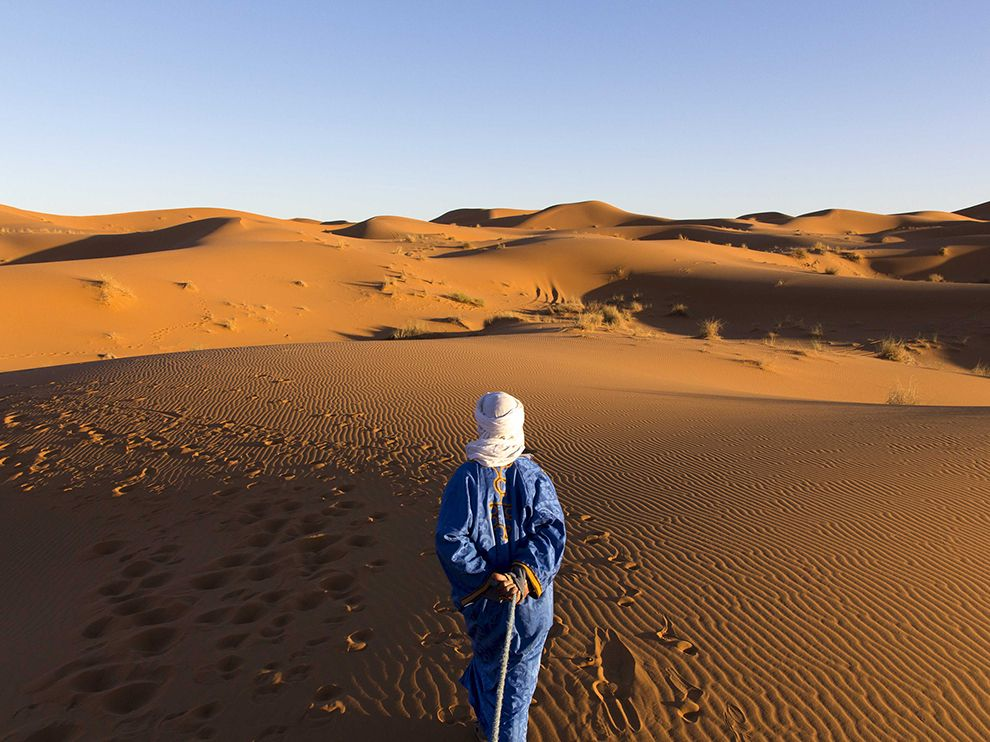

In [54]:
Image(filename = base_path)

##### Style image

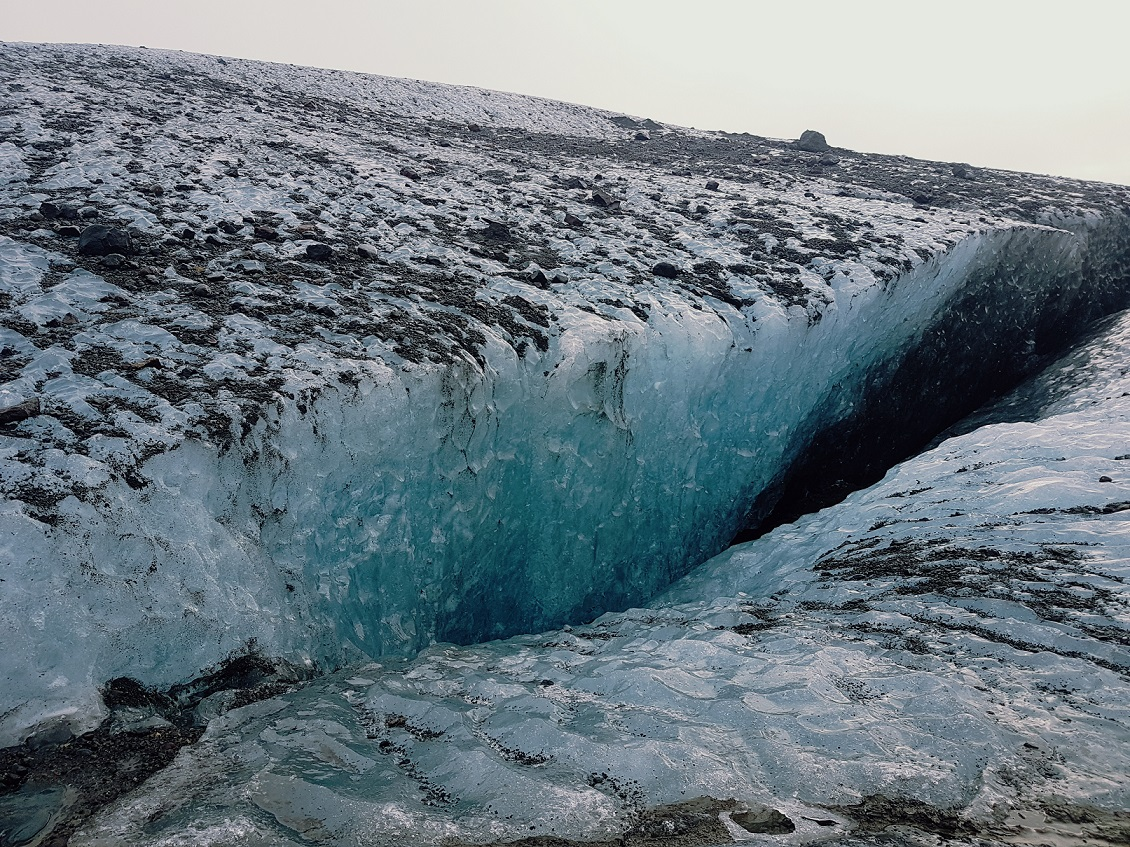

In [55]:
Image(style_path)

# Building model

## Preprocessing

The base image size is 

In [56]:
scipy.misc.imread(base_path,flatten = False).shape

(742, 990, 3)

In [57]:
def preprocess_image(filename):
    img = scipy.misc.imread(filename,flatten = False)
    img = scipy.misc.imresize(img,(724,990),'cubic')
    img = np.asarray(img,dtype = "float32")
    img = np.expand_dims(img,axis = 0)
    img = preprocess_input(img)
    return img

In [58]:
base_shape = preprocess_image(base_path).shape
base_shape

(1, 724, 990, 3)

In [68]:
height = base_shape[1]
width = base_shape[2]

In [59]:
preprocess_image(style_path).shape

(1, 724, 990, 3)

## Prepare the tensors and model
##### Concatenate the two images in a tensor

In [60]:
# Create the three tensors
base_image = backend.variable(preprocess_image(base_path))
style_image = backend.variable(preprocess_image(style_path))
combination_image = backend.placeholder(base_shape)

# Concatenate them
input_tensor = backend.concatenate([base_image,style_image,combination_image],axis = 0)

##### Loading the pre-trained VGG-16 model

In [61]:
model = VGG16(input_tensor = input_tensor,weights='imagenet', include_top=False)

##### Looking at the different layers

In [66]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 724, 990, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 724, 990, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 362, 495, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 362, 495, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 362, 495, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 181, 247, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 181, 247, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 181, 247, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 181, 247, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 90, 123, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(3, 90, 123, 

##### Defining some parameters

In [62]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

## Define the losses

### Initialize the loss

In [64]:
loss = backend.variable(0.)

### Content loss

In [67]:
def calculate_content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

content_loss = content_weight * calculate_content_loss(content_image_features,combination_features)

### Style loss

In [70]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [71]:
def calculate_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = (style_weight / len(feature_layers)) * calculate_style_loss(style_features, combination_features)

### Variation loss

In [72]:
def calculate_total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

variation_loss = total_variation_weight * calculate_total_variation_loss(combination_image)

### Total loss

In [73]:
loss = loss + style_loss + content_loss + variation_loss

In [74]:
loss

<tf.Tensor 'add_3:0' shape=() dtype=float32>

## Optimization

### Getting the gradient of the generated image with respect to the loss

In [75]:
gradients = backend.gradients(loss,combination_image)
print(gradients)

[<tf.Tensor 'gradients/AddN_4:0' shape=(1, 724, 990, 3) dtype=float32>]


### Define an evaluator

In [77]:
outputs = [loss]
outputs += gradients
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [78]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Run the optimizer (L-BGFS) to minimize the loss

In [83]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.58901e+10
Iteration 0 completed in 1946s
Start of iteration 1
Current loss value: 1.23867e+10
Iteration 1 completed in 2504s
Start of iteration 2
Current loss value: 1.0365e+10
Iteration 2 completed in 1828s
Start of iteration 3
Current loss value: 9.12541e+09
Iteration 3 completed in 1665s
Start of iteration 4
Current loss value: 8.16813e+09
Iteration 4 completed in 2398s
Start of iteration 5
Current loss value: 7.49596e+09
Iteration 5 completed in 1530s
Start of iteration 6
Current loss value: 6.97923e+09
Iteration 6 completed in 1504s
Start of iteration 7
Current loss value: 6.52608e+09
Iteration 7 completed in 1474s
Start of iteration 8
Current loss value: 6.08113e+09
Iteration 8 completed in 1500s
Start of iteration 9
Current loss value: 5.69607e+09
Iteration 9 completed in 1501s


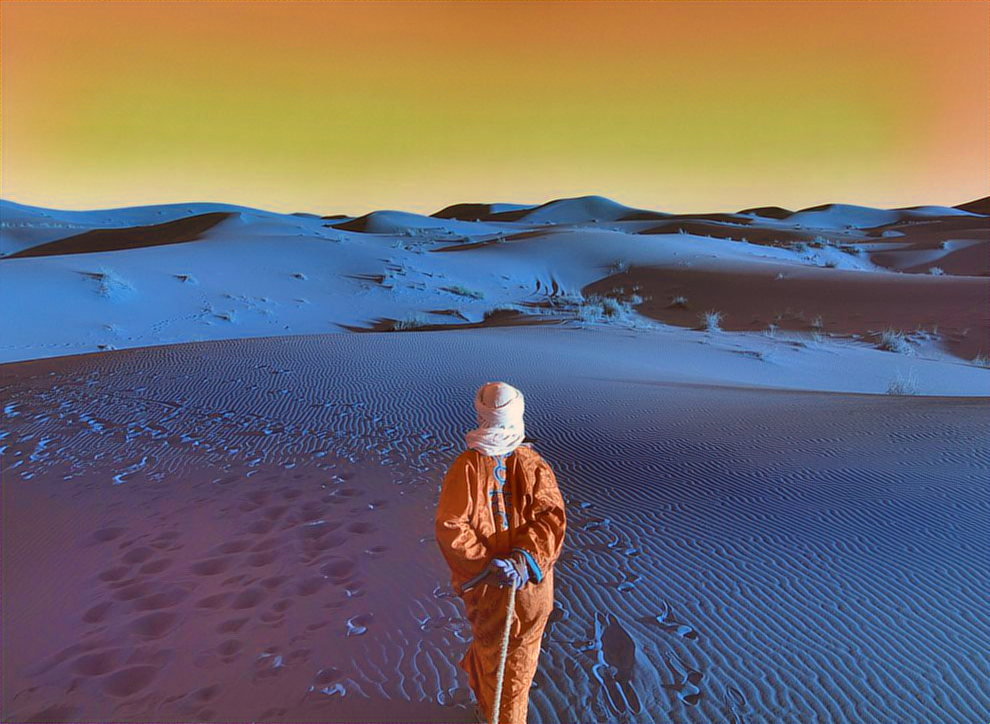

In [86]:
from PIL import Image

Image.fromarray(x)